# Exercise 2: Convolution GAN for MNIST digits

## Cristian CHÁVEZ

This practical session is based on the [DCGAN Pytorch tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html).

It was adapted by
* Lucía Bouza
* Bruno Galerne
* Arthur Leclaire

You should complete the code regions marked with ###...###.

## Import

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
import torchvision.utils as vutils
import torch.utils.data as data

import matplotlib.pyplot as plt
import os
import numpy as np
import time

import torchvision

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device is", device)
# !nvidia-smi

# Displaying function
def imshow(img,size=None):
    img = img*0.5 + 0.5     # unnormalize
    if size is not None:
        img = transforms.Resize(size=size, interpolation=transforms.InterpolationMode.NEAREST, antialias=True)(img)
    pil_img = torchvision.transforms.functional.to_pil_image(img)
    display(pil_img)
    # print("Image size (h x w): ",  pil_img.height, "x", pil_img.width)
    return None

Device is cuda


## Download MNIST dataset

Note that we normalize the images between -1 and 1 because during sampling, we have to limit the input space and scaling between -1 and 1 makes it easier to implement it. We discard the last batch so that all batches have the same size.

In [ ]:
batch_size=128
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])
train_set = MNIST(os.getcwd(), train=True, transform=transform, download=True)
train_loader = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:02<00:00, 4595324.49it/s]


Extracting /content/MNIST/raw/train-images-idx3-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 136628.86it/s]


Extracting /content/MNIST/raw/train-labels-idx1-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1269501.06it/s]


Extracting /content/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9974098.83it/s]

Extracting /content/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/MNIST/raw



QUESTION: Draw a batch of real images with the train_loader and display them. Use `next` and `iter` to get a batch from `train_loader`.

torch.Size([128, 1, 28, 28])


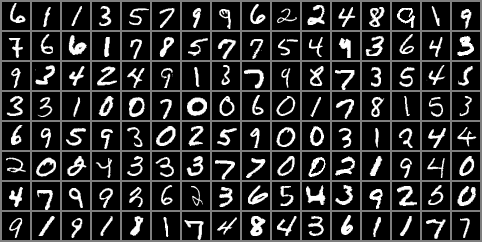

In [ ]:
real,_ = next(iter(train_loader))
print(real.shape)

pil_img = imshow(torchvision.utils.make_grid(real.to('cpu'),nrow=16))

## Generator and Discriminator Models

The architecture of DCGAN is described in the [(Radford et al., 2016)](https://arxiv.org/pdf/1511.06434.pdf)

QUESTION: Examine the architecture of the following generator and discriminator.

In [ ]:
# Size  of generator input
nz = 100

# Size of feature maps in generator and discriminator
ngf, ndf = 64, 64

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(in_channels = nz, out_channels = ngf * 8, kernel_size = 4, stride = 1, padding = 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(in_channels = ngf * 8, out_channels = ngf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(in_channels = ngf * 4, out_channels = ngf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(in_channels = ngf * 2, out_channels = ngf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(in_channels = ngf, out_channels = 1, kernel_size=1, stride=1, padding=2, bias=False),
            nn.Tanh()
            # output size. 1 x 28 x 28
        )

    def forward(self, input):
        return self.main(input)


class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            # input is 1 x 28 x 28
            nn.Conv2d(in_channels = 1, out_channels = ndf, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 15 x 15
            nn.Conv2d(in_channels = ndf, out_channels= ndf * 2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(in_channels = ndf * 2, out_channels = ndf * 4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 5 x 5
            nn.Conv2d(in_channels = ndf * 4, out_channels = 1, kernel_size = 4, stride = 2, padding = 1, bias=False)
        )

    def forward(self, input):
        return self.main(input).view(-1, 1).squeeze(1)

# check sizes:
import torchsummary
# Create some generator and discriminator
netG = Generator().to(device)
netD = Discriminator().to(device)
torchsummary.summary(netG, input_size=(nz,1,1))
torchsummary.summary(netD, input_size=(1,28,28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
       BatchNorm2d-2            [-1, 512, 4, 4]           1,024
              ReLU-3            [-1, 512, 4, 4]               0
   ConvTranspose2d-4            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-5            [-1, 256, 8, 8]             512
              ReLU-6            [-1, 256, 8, 8]               0
   ConvTranspose2d-7          [-1, 128, 16, 16]         524,288
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
  ConvTranspose2d-10           [-1, 64, 32, 32]         131,072
      BatchNorm2d-11           [-1, 64, 32, 32]             128
             ReLU-12           [-1, 64, 32, 32]               0
  ConvTranspose2d-13            [-1, 1, 28, 28]              64
             Tanh-14            [-1, 1,

## Display Samples of the Generator

In [ ]:
# function to display samples of the generator
def show(G,z=None,batch_size=128,nz=100):
  # provide random latent code as option to see evolution
  with torch.no_grad():
    if z==None:
      z = torch.randn(batch_size,nz,1,1).to(device)
    genimages = G(z)
    pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=16))
    return(pil_img)

## Weight initialization

The DCGAN [paper](https://arxiv.org/pdf/1511.06434.pdf) mentions that all model weights shall be randomly initialized from a Normal distribution with $\mu=0$ and $\sigma=0.02$. We implement `weights_init` function to reinitialize the weights.

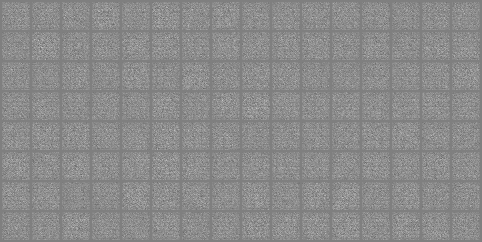

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Create the generator and discriminator
G = Generator().to(device)
D = Discriminator().to(device)

# Apply the weights_init function to randomly initialize all weights to mean=0, stdev=0.02.
G.apply(weights_init);
D.apply(weights_init);

show(G);

<br/><br/><br/><br/><br/>

# Part 1: DCGAN Training with WGAN-GP loss

<br/><br/>
**QUESTION:** Implement WGAN-GP training for MNIST by completing the code in the following cell.
We recall the pseudo-code:

> For each batch of images $x_{\text{real}}$:
>
> **1) Train discriminator:**
> > Generate $z$ a tensor of size $b\times nz\times 1\times 1$ of idd Gaussian variables  
> > Generate  $x_{\text{fake}} = \mathtt{G}(z)$ a set $b$ fake images  
> > Compute the discriminator loss to maximize <br/>
> > Compute the gradient and do an optimizer step for the disciminator parameters  
>
> **2) Train the generator:**
> > Generate $z$ a new tensor of size $b\times nz\times 1\times 1$ of idd Gaussian variables  
> > Compute the generator loss to minimize <br/>
> > Compute the gradient and do an optimizer step for the generator parameters

In [ ]:
def lipconstant(D, x, y):
    b = x.shape[0]
    n = y.shape[0]

    # shrink vectors if they are too large
    if n > b:
        y = y[0:b, :]
        n = b
    else:
        x = x[0:n, :]
        b = n

    # compute interpolated points
    alpha = torch.rand((b, 1, 1, 1), device=device)
    interp = (alpha * y + (1 - alpha) * x)
    interp.requires_grad_()

    # Calculate probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
                                    create_graph=True, retain_graph=True)[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=(1, 2, 3)) + 1e-11)

    # Return Lipschitz constant
    return torch.mean(gradients_norm)


def gradient_penalty(D, x, y):
    b = x.shape[0]
    n = y.shape[0]

    # shrink vectors if they are too large
    if n > b:
        y = y[0:b, :]
        n = b
    else:
        x = x[0:n, :]
        b = n

    # compute interpolated points
    alpha = torch.rand((b, 1, 1, 1), device=device)
    interp = (alpha * y + (1 - alpha) * x)
    interp.requires_grad_()

    # Calculate probability of interpolated examples
    Di = D(interp).view(-1)

    # Calculate gradients of probabilities with respect to examples
    gradout = torch.ones(Di.size()).to(device)
    gradients = torch.autograd.grad(outputs=Di, inputs=interp, grad_outputs=gradout,
                                    create_graph=True, retain_graph=True)[0]

    # Derivatives of the gradient close to 0 can cause problems because of
    # the square root, so manually calculate norm and add epsilon
    gradients_norm = torch.sqrt(torch.sum(gradients ** 2, dim=(1, 2, 3)) + 1e-11)

    # Return gradient penalty
    return ((gradients_norm - 1) ** 2).mean()


# Test lipconstant and gradient_penalty functions
y = next(iter(train_loader))[0].to(device)
x = G(torch.randn(batch_size, nz, 1, 1, device=device)).detach()

print(lipconstant(D, x, y))
print(gradient_penalty(D, x, y))


tensor(3.6368, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(7.8584, device='cuda:0', grad_fn=<MeanBackward0>)


[1/10][0/468][0.2653 s]	Loss_D: -0.1879	Loss_G: 0.1086	Lip(D): 1.8241


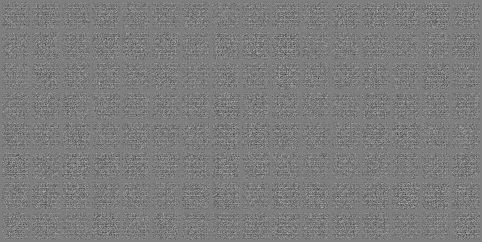

[1/10][100/468][13.6054 s]	Loss_D: -10.3931	Loss_G: 7.0775	Lip(D): 3.8742


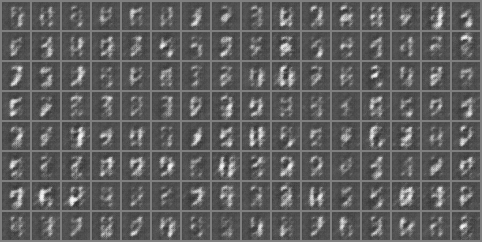

[1/10][200/468][27.1519 s]	Loss_D: -39.1626	Loss_G: 6.9294	Lip(D): 6.7182


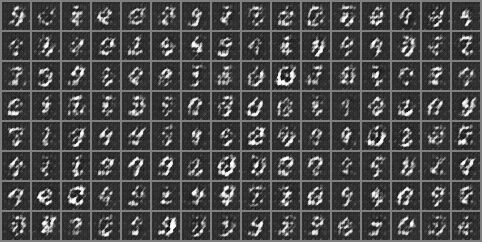

[1/10][300/468][40.9276 s]	Loss_D: -72.1577	Loss_G: 20.7741	Lip(D): 7.0245


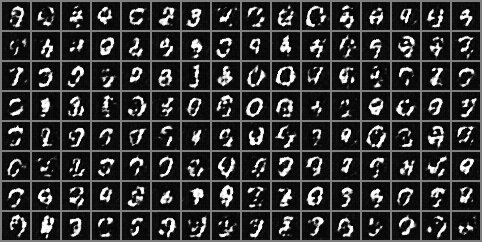

[1/10][400/468][54.6818 s]	Loss_D: -39.9698	Loss_G: 61.7807	Lip(D): 5.9724


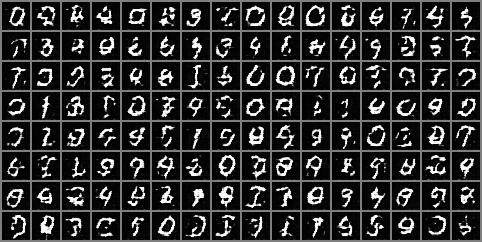

[2/10][0/468][64.0534 s]	Loss_D: -48.4085	Loss_G: 30.6511	Lip(D): 6.7817


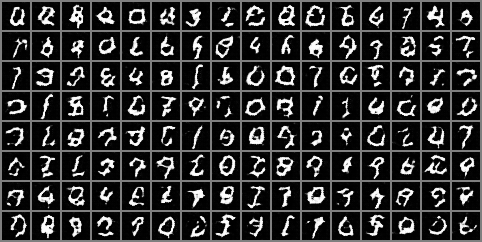

[2/10][100/468][77.5560 s]	Loss_D: -35.0697	Loss_G: 15.5513	Lip(D): 7.9655


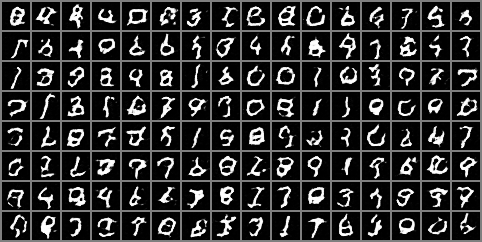

[2/10][200/468][90.9704 s]	Loss_D: -28.8124	Loss_G: 4.6929	Lip(D): 5.8576


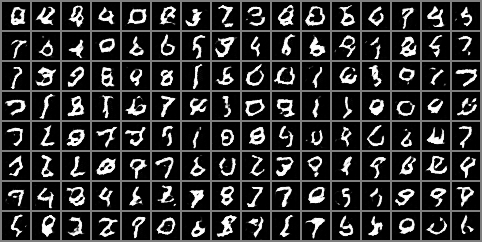

[2/10][300/468][104.4290 s]	Loss_D: -52.5844	Loss_G: 92.0464	Lip(D): 7.6109


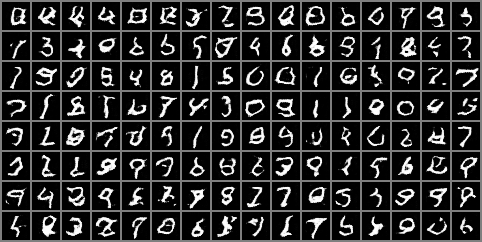

[2/10][400/468][117.9366 s]	Loss_D: -6.7883	Loss_G: -11.6643	Lip(D): 6.8073


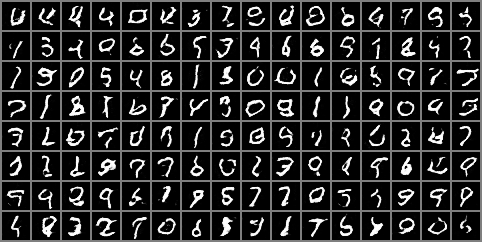

[3/10][0/468][127.2684 s]	Loss_D: -40.6518	Loss_G: 73.3267	Lip(D): 5.8967


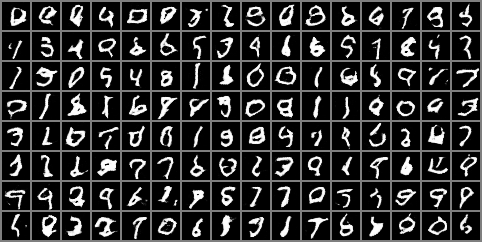

[3/10][100/468][140.8204 s]	Loss_D: -27.6794	Loss_G: 57.7385	Lip(D): 8.3152


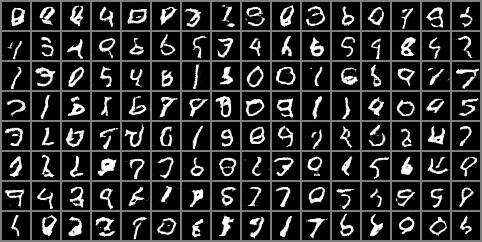

[3/10][200/468][154.3508 s]	Loss_D: -30.6740	Loss_G: 63.0300	Lip(D): 7.0931


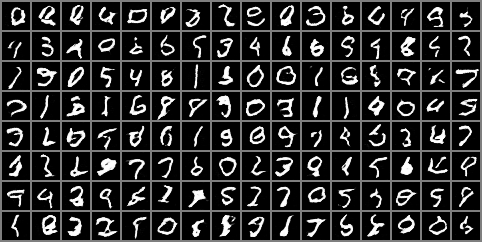

[3/10][300/468][167.8478 s]	Loss_D: -44.9298	Loss_G: 86.7902	Lip(D): 5.7114


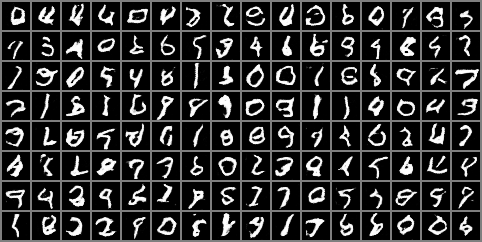

[3/10][400/468][181.3398 s]	Loss_D: -20.7128	Loss_G: 55.1339	Lip(D): 7.2600


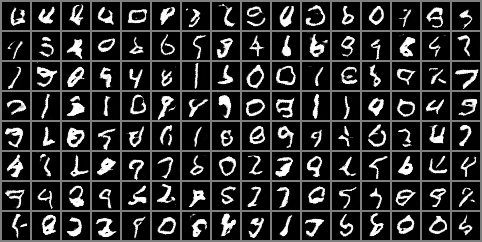

[4/10][0/468][190.6407 s]	Loss_D: -18.9015	Loss_G: 99.4546	Lip(D): 7.8828


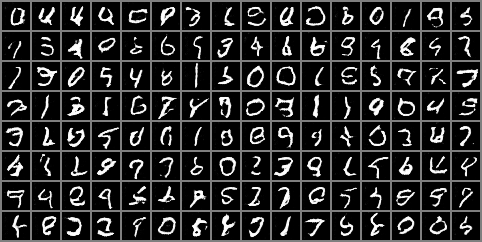

[4/10][100/468][204.1382 s]	Loss_D: -27.3550	Loss_G: 28.2799	Lip(D): 7.0291


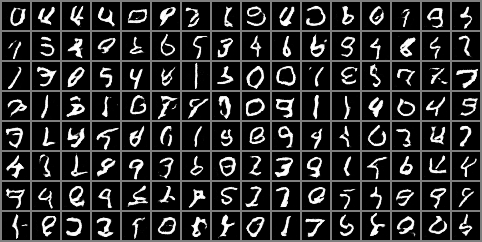

[4/10][200/468][217.6185 s]	Loss_D: -35.4832	Loss_G: 93.3303	Lip(D): 8.5692


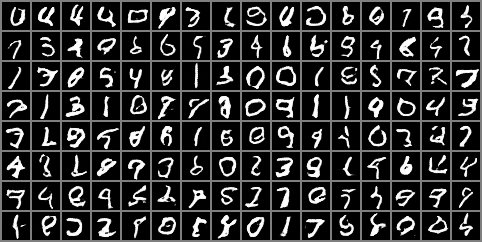

[4/10][300/468][231.1193 s]	Loss_D: -22.9576	Loss_G: 78.7612	Lip(D): 6.3735


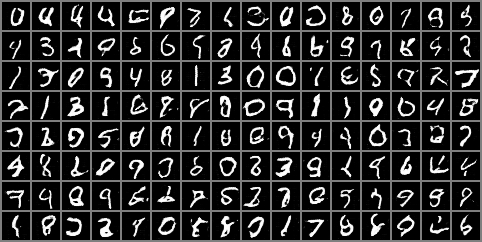

[4/10][400/468][244.6015 s]	Loss_D: -25.3906	Loss_G: 103.9972	Lip(D): 6.3553


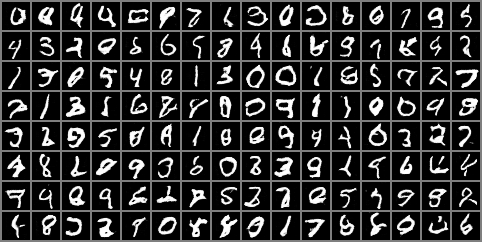

[5/10][0/468][253.9440 s]	Loss_D: -26.3899	Loss_G: 146.3574	Lip(D): 5.1244


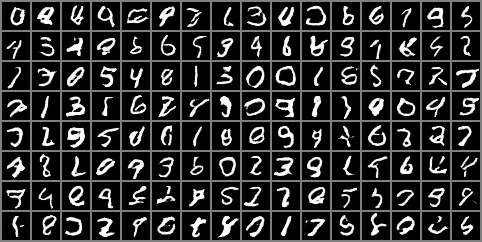

[5/10][100/468][267.4369 s]	Loss_D: -61.6490	Loss_G: 70.2200	Lip(D): 10.4857


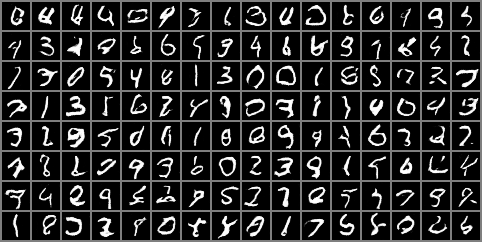

[5/10][200/468][280.9431 s]	Loss_D: 22.0753	Loss_G: 45.4934	Lip(D): 6.8636


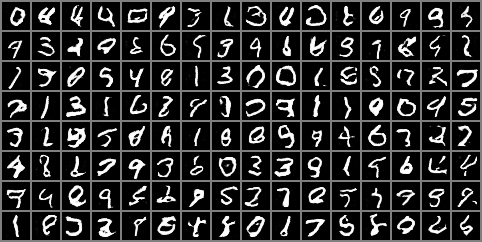

[5/10][300/468][294.4509 s]	Loss_D: -18.6354	Loss_G: 222.1052	Lip(D): 6.2073


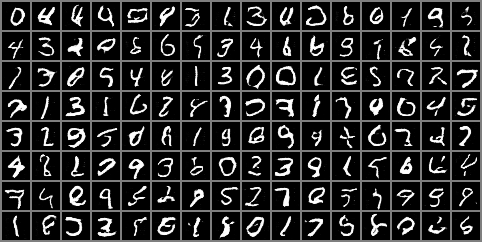

[5/10][400/468][307.9432 s]	Loss_D: -46.3871	Loss_G: 172.4693	Lip(D): 5.2966


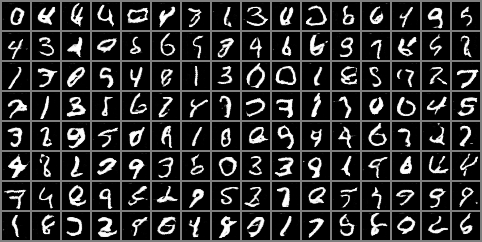

[6/10][0/468][317.2583 s]	Loss_D: -56.1181	Loss_G: 87.1486	Lip(D): 10.0295


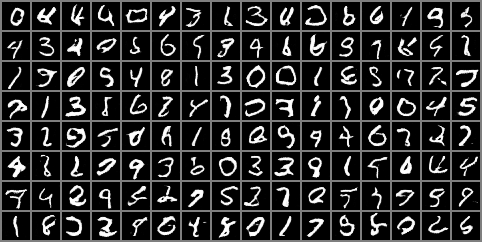

[6/10][100/468][330.7651 s]	Loss_D: -7.0550	Loss_G: 94.5018	Lip(D): 5.9351


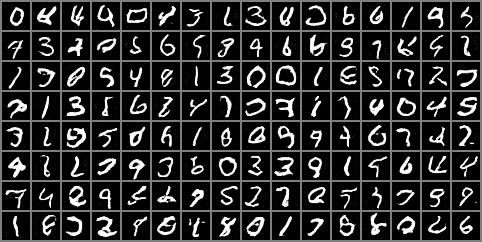

[6/10][200/468][344.2675 s]	Loss_D: 3.7914	Loss_G: 131.1890	Lip(D): 8.0857


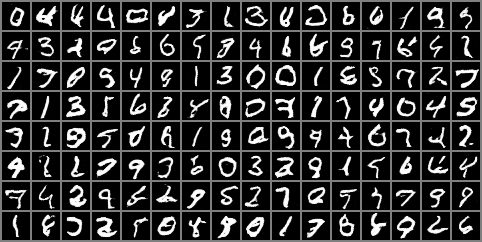

[6/10][300/468][357.7540 s]	Loss_D: -5.7203	Loss_G: 138.0002	Lip(D): 6.7117


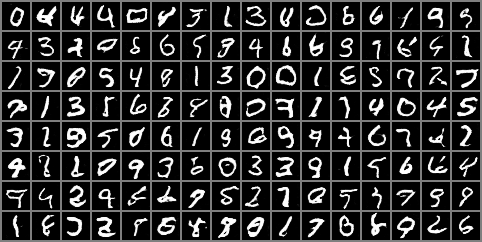

[6/10][400/468][371.2281 s]	Loss_D: -10.6671	Loss_G: 124.3707	Lip(D): 6.1887


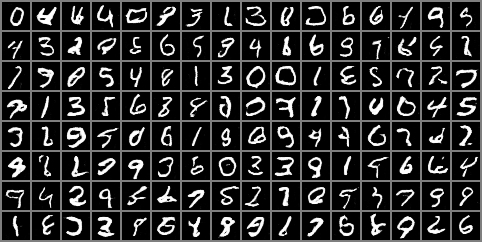

[7/10][0/468][380.5386 s]	Loss_D: -18.4149	Loss_G: 167.7366	Lip(D): 6.4396


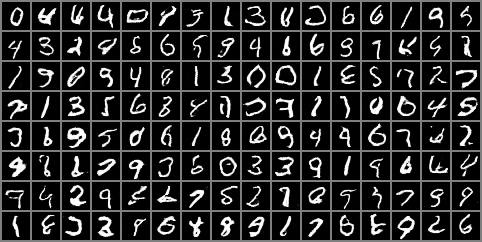

[7/10][100/468][394.0571 s]	Loss_D: -26.4402	Loss_G: 195.6683	Lip(D): 7.9294


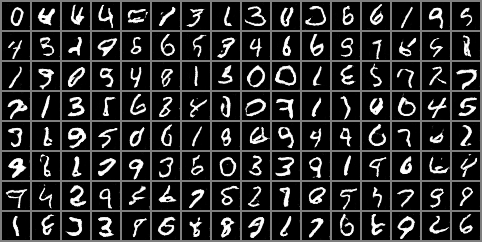

[7/10][200/468][407.5777 s]	Loss_D: -17.9573	Loss_G: 121.4230	Lip(D): 6.2134


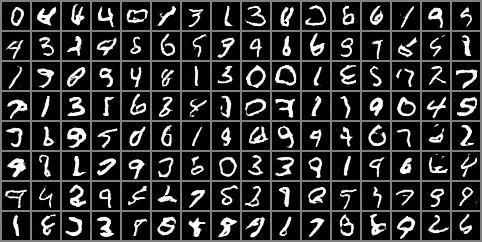

[7/10][300/468][421.0812 s]	Loss_D: -12.9538	Loss_G: 151.6590	Lip(D): 6.1291


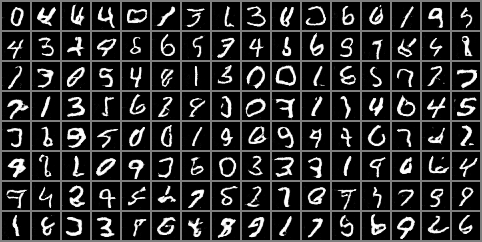

[7/10][400/468][434.5983 s]	Loss_D: -25.3051	Loss_G: 151.0448	Lip(D): 5.7255


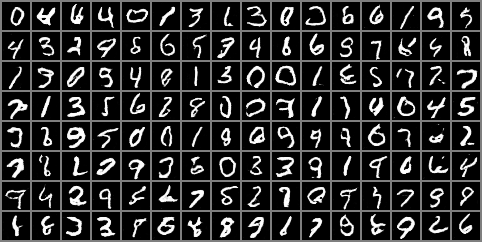

[8/10][0/468][444.0111 s]	Loss_D: -31.9592	Loss_G: 155.8783	Lip(D): 7.6056


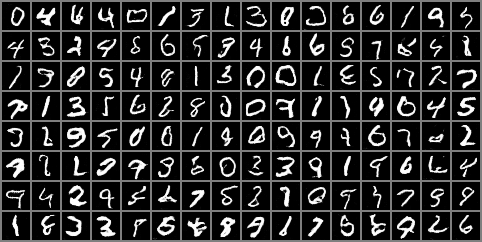

[8/10][100/468][457.5600 s]	Loss_D: -15.4160	Loss_G: 194.2283	Lip(D): 5.7428


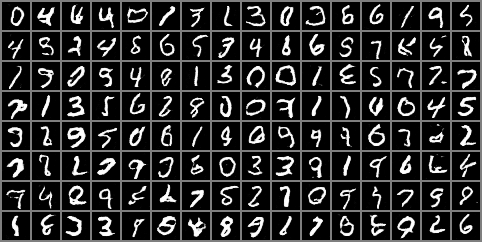

[8/10][200/468][471.0748 s]	Loss_D: -1.9936	Loss_G: 220.5953	Lip(D): 7.2901


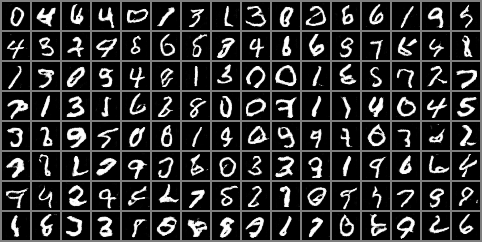

[8/10][300/468][484.6879 s]	Loss_D: -12.0791	Loss_G: 182.5392	Lip(D): 7.0354


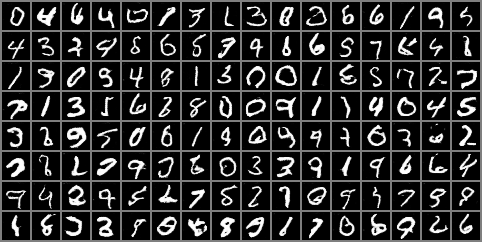

[8/10][400/468][498.2277 s]	Loss_D: -11.8856	Loss_G: 191.6960	Lip(D): 6.2365


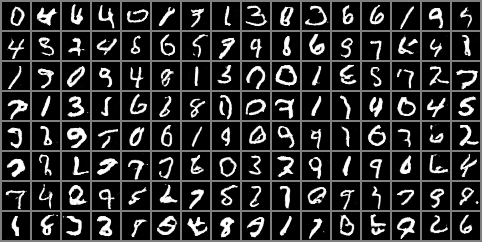

[9/10][0/468][507.6886 s]	Loss_D: -0.2366	Loss_G: 222.4473	Lip(D): 4.5445


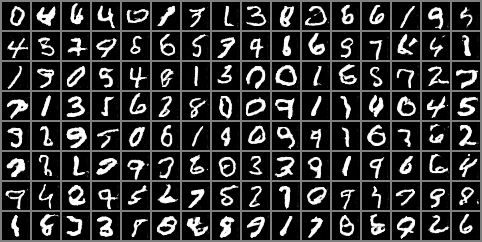

[9/10][100/468][521.2238 s]	Loss_D: -15.3492	Loss_G: 173.5063	Lip(D): 6.4480


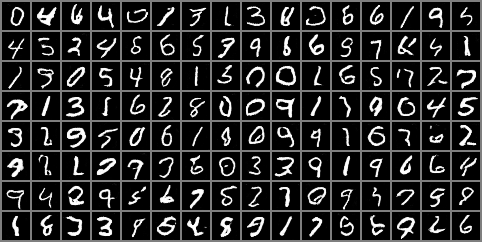

[9/10][200/468][534.7268 s]	Loss_D: -4.8527	Loss_G: 171.4165	Lip(D): 5.9767


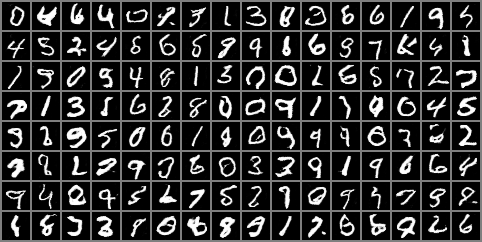

[9/10][300/468][548.2670 s]	Loss_D: -14.2273	Loss_G: 163.6711	Lip(D): 5.3116


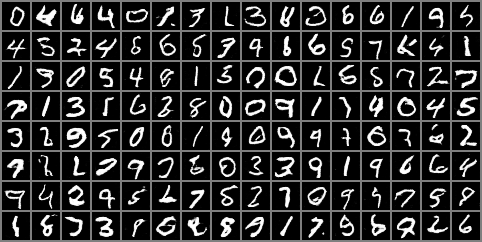

[9/10][400/468][561.8075 s]	Loss_D: -6.0308	Loss_G: 229.2957	Lip(D): 4.8655


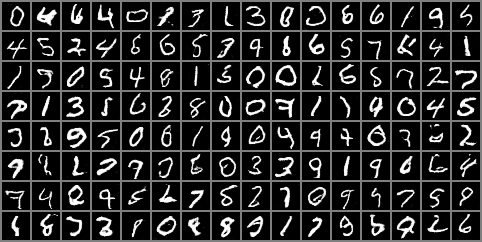

[10/10][0/468][571.2086 s]	Loss_D: -10.0006	Loss_G: 138.3004	Lip(D): 6.9099


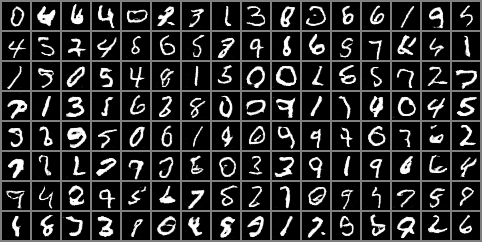

[10/10][100/468][584.7562 s]	Loss_D: -11.6858	Loss_G: 154.2465	Lip(D): 5.1433


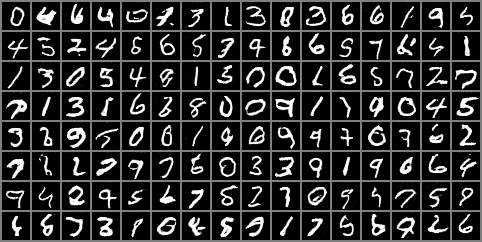

[10/10][200/468][598.2915 s]	Loss_D: -12.1600	Loss_G: 214.1544	Lip(D): 5.6502


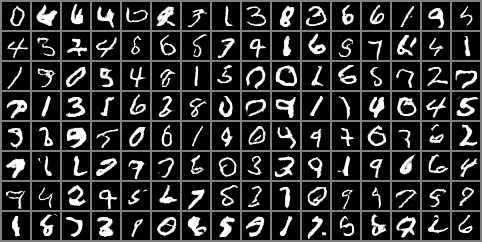

[10/10][300/468][611.8222 s]	Loss_D: -8.6120	Loss_G: 178.6730	Lip(D): 5.6611


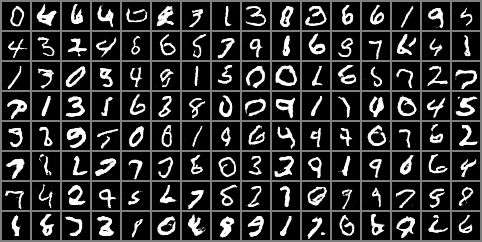

[10/10][400/468][625.3425 s]	Loss_D: -12.9552	Loss_G: 237.5768	Lip(D): 5.5269


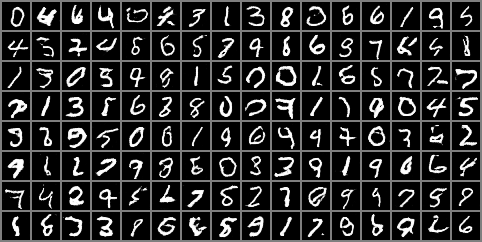

Total learning time =  634.4588432312012


<All keys matched successfully>

In [ ]:
torch.manual_seed(1)  # initialize random seed for reproducibility

num_epochs = 10
log_every = 100
gpw = 0.1

G = Generator().to(device)
D = Discriminator().to(device)
G.apply(weights_init)
D.apply(weights_init)

optimD = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimG = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

zviz = torch.randn(batch_size, nz, 1, 1).to(device)

t0 = time.time()
for epoch in range(num_epochs):
    # For each batch in the train_loader
    for i, batch in enumerate(train_loader, 0):

        ############################
        # Batchs of real and fake images
        real = batch[0].to(device)
        fake = G(torch.randn(batch_size, nz, 1, 1, device=device))
        faked = fake.detach()

        ############################
        # Update D network
        optimD.zero_grad()
        Dloss = -(torch.mean(D(real)) - torch.mean(D(fake))) + gpw * gradient_penalty(D, real, faked)
        Dloss.backward()
        optimD.step()

        ############################ Generate fake data
        # Batchs of real and fake images
        real = batch[0].to(device)
        fake = G(torch.randn(batch_size, nz, 1, 1, device=device))

        ############################
        # Update G network
        optimG.zero_grad()
        #cambiar el fake
        Gloss = -torch.mean(D(fake))
        Gloss.backward()
        optimG.step()

        ############################
        # Display training stats and visualize
        if i % log_every == 0:
            print('[%d/%d][%d/%d][%.4f s]\tLoss_D: %.4f\tLoss_G: %.4f\tLip(D): %.4f'
                  % (epoch+1, num_epochs, i, len(train_loader), time.time()-t0, Dloss.item(), Gloss.item(), lipconstant(D, real, faked)))
            show(G, zviz)

print('Total learning time = ', time.time()-t0)

# Save final generator in a variable for later use
wgan = Generator()
wgan.load_state_dict(G.state_dict())


In [ ]:
# Save final generator for later use
torch.save(G.state_dict(), 'wgan.pt')
wgan = Generator()
wgan.load_state_dict(G.state_dict())


<All keys matched successfully>

<br/><br/><br/><br/><br/>

# Part 2 BONUS: Let's play with the Generator

## Interpolation in latent space:

**QUESTION:**
Generate 2 sets of 10 latent variable $z_0$ and $z_1$ and display the generated images by the latent variables:
$$
z_\alpha = (1-\alpha) z_0 + \alpha z_1
$$
for $\alpha$ varying between $0$ and $1$.

Display all the images in a grid of height 10 and width 20 images.

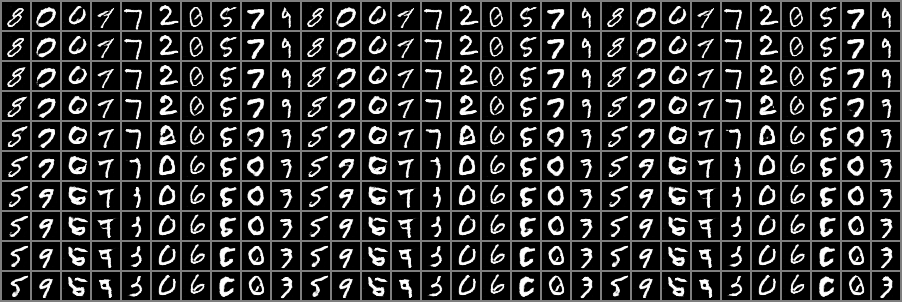

In [ ]:
# You may load a trained generator from a file
G = Generator().to(device)
G.load_state_dict(torch.load('wgan.pt'))
G.eval();  # Turn generator in evaluation mode to fix BatchNorm layers

minib = 10
nk = 30

z0 = torch.randn(minib, nz, 1, 1, device=device)
z1 = torch.randn(minib, nz, 1, 1, device=device)

genimages = torch.zeros((minib*nk,1,28,28))
for k in np.arange(nk):
    alpha = k / (nk - 1)  # Vary alpha from 0 to 1
    z_alpha = (1 - alpha) * z0 + alpha * z1
    with torch.no_grad():
        gen_batch = G(z_alpha).cpu()
    genimages[k*minib:(k+1)*minib] = gen_batch

pil_img = imshow(torchvision.utils.make_grid(genimages.to('cpu'),nrow=nk))

## Nearest Neighbor in the Dataset

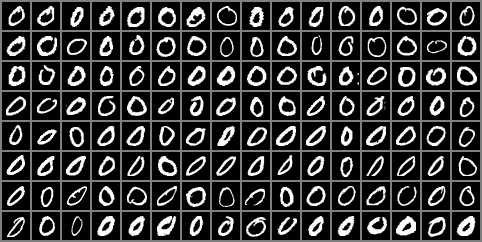

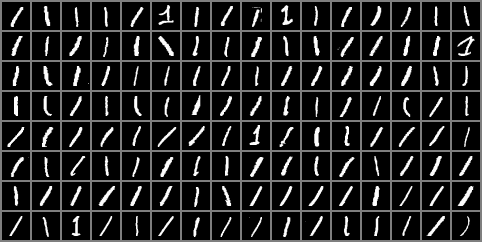

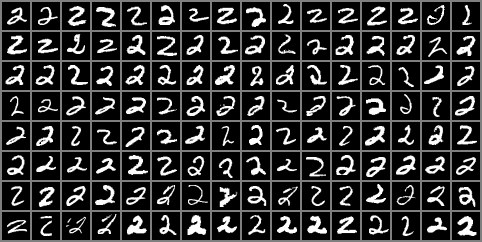

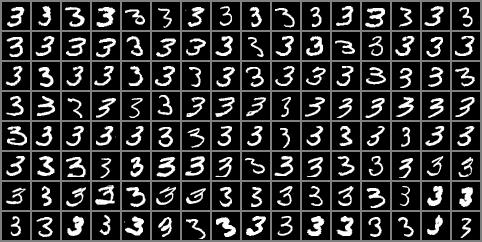

In [ ]:
# load all the database
train_loader_all = data.DataLoader(train_set, batch_size=60000, shuffle=False, num_workers=2, drop_last=True)
y,labels = next(iter(train_loader_all))

realzeros = y[labels==0]
realones = y[labels==1]
realtwos = y[labels==2]
realthrees = y[labels==3]
imshow(torchvision.utils.make_grid(realzeros[0:128,:,:,:].to('cpu'),nrow=16));
imshow(torchvision.utils.make_grid(realones[0:128,:,:,:].to('cpu'),nrow=16));
imshow(torchvision.utils.make_grid(realtwos[0:128,:,:,:].to('cpu'),nrow=16));
imshow(torchvision.utils.make_grid(realthrees[0:128,:,:,:].to('cpu'),nrow=16));

**QUESTION:** For several samples of the generative model, compute the nearest neighbors in the whole dataset.

Display the samples and their nearest neighbor side by side.

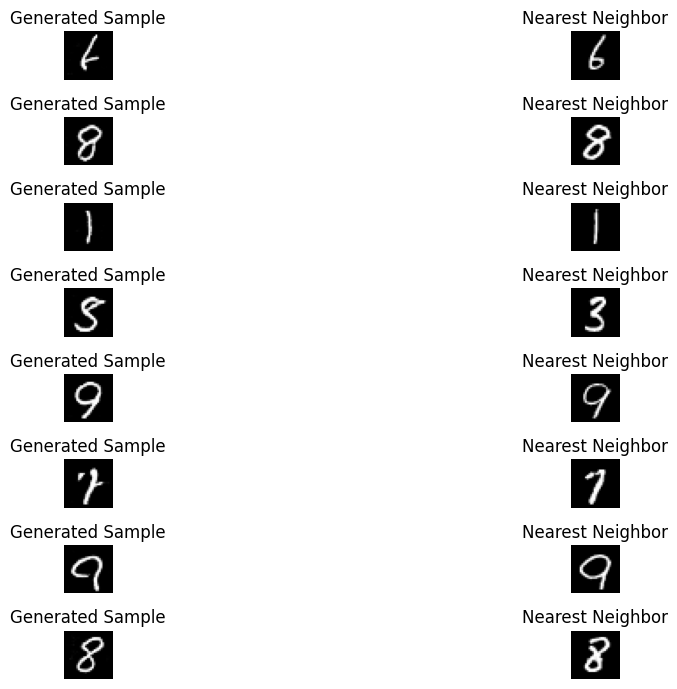

In [ ]:
### ... ###

from sklearn.metrics import pairwise_distances_argmin_min

# Function to compute nearest neighbors
def compute_nearest_neighbors(samples, dataset):
    # Detach samples
    samples_detached = samples.detach().cpu()

    # Reshape samples for compatibility with pairwise_distances_argmin_min
    samples_flat = samples_detached.view(samples_detached.size(0), -1)

    # Reshape dataset for compatibility with pairwise_distances_argmin_min
    dataset_flat = dataset.view(dataset.size(0), -1)

    # Compute pairwise distances between samples and dataset
    nearest_indices, distances = pairwise_distances_argmin_min(samples_flat.cpu().numpy(), dataset_flat.cpu().numpy())

    return distances, nearest_indices

# Function to display samples and their nearest neighbors side by side
def display_nearest_neighbors(samples, nearest_indices, dataset, nrow=4):
    plt.figure(figsize=(15, 7))
    for i in range(samples.size(0)):
        plt.subplot(samples.size(0), 2, 2*i+1)
        plt.imshow(samples[i].squeeze().detach().cpu().numpy(), cmap='gray')  # Detach tensor before conversion
        plt.title("Generated Sample")
        plt.axis('off')

        plt.subplot(samples.size(0), 2, 2*i+2)
        nn_index = int(nearest_indices[i])  # Convert to integer
        plt.imshow(dataset[nn_index].squeeze().detach().cpu().numpy(), cmap='gray')  # Detach tensor before conversion
        plt.title("Nearest Neighbor")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Generate samples from the generator
num_samples = 8
generated_samples = G(torch.randn(num_samples, nz, 1, 1, device=device)).cpu()

# Compute nearest neighbors for generated samples
distances, nearest_indices = compute_nearest_neighbors(generated_samples, y)

# Display samples and their nearest neighbors
display_nearest_neighbors(generated_samples, nearest_indices, y)
